In [1]:

import os
import zipfile
from PIL import Image
import torch
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd


nltk.download('punkt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
os.makedirs("Flickr8k_Dataset", exist_ok=True)
os.makedirs("Flickr8k_text", exist_ok=True)

if not os.path.exists("Flickr8k_Dataset.zip"):
    os.system("wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip -O Flickr8k_Dataset.zip")
if not os.path.exists("Flickr8k_text.zip"):
    os.system("wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip -O Flickr8k_text.zip")

with zipfile.ZipFile("Flickr8k_Dataset.zip","r") as z: z.extractall("Flickr8k_Dataset")
with zipfile.ZipFile("Flickr8k_text.zip","r")   as z: z.extractall("Flickr8k_text")


In [3]:
refs = {}
with open("Flickr8k_text/Flickr8k.token.txt","r") as f:
    for line in f:
        imgcap, txt = line.strip().split("\t")
        img = imgcap.split("#")[0]
        refs.setdefault(img, []).append(txt.lower().split())

test_images = set(open("Flickr8k_text/Flickr_8k.testImages.txt").read().splitlines())


In [4]:
model_name = "nlpconnect/vit-gpt2-image-captioning"
model = VisionEncoderDecoderModel.from_pretrained(model_name).to(device)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


tokenizer.add_special_tokens({"pad_token":"<pad>"})
model.decoder.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id
model.config.decoder.pad_token_id = tokenizer.pad_token_id

gen_kwargs = {
    "max_length":16,
    "num_beams":4,
    "length_penalty":1.0,
    "no_repeat_ngram_size":2
}

def generate_caption(path):
    img = Image.open(path).convert("RGB")
    pixels = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)
    ids = model.generate(pixels,
                         pad_token_id=tokenizer.pad_token_id,
                         eos_token_id=tokenizer.eos_token_id,
                         **gen_kwargs)
    return tokenizer.decode(ids[0], skip_special_tokens=True).split()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_to

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [5]:
hypotheses = []
references_list = []
image_names = []
img_dir = "Flickr8k_Dataset/Flicker8k_Dataset"

for img in tqdm(sorted(test_images)):
    path = os.path.join(img_dir, img)
    if not os.path.exists(path):
        continue
    hyp = generate_caption(path)
    hypotheses.append(hyp)
    references_list.append(refs[img])
    image_names.append(img)

print(f"Generated captions for {len(hypotheses)} images")


  0%|          | 0/1000 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.
100%|██████████| 1000/1000 [04:46<00:00,  3.49it/s]

Generated captions for 1000 images


In [17]:
nltk.download('wordnet')
nltk.download('omw-1.4')
smooth = SmoothingFunction().method4
weights = {
    "BLEU-1": (1,0,0,0),
    "BLEU-2": (0.5,0.5,0,0),
    "BLEU-3": (1/3,1/3,1/3,0),
    "BLEU-4": (0.25,0.25,0.25,0.25)
}

agg_scores = {}
for name, w in weights.items():
    agg_scores[name] = corpus_bleu(
        references_list, hypotheses,
        weights=w, smoothing_function=smooth
    )


per_img_meteor = [
    meteor_score(ref_list, hyp)
    for ref_list, hyp in zip(references_list, hypotheses)
]
agg_scores["METEOR"] = sum(per_img_meteor) / len(per_img_meteor)

metrics_df = pd.DataFrame.from_dict(
    agg_scores, orient='index', columns=['Score']
)
metrics_df


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,Score
BLEU-1,0.611948
BLEU-2,0.417242
BLEU-3,0.269282
BLEU-4,0.170619
METEOR,0.367073


In [9]:
per_image_bleu4 = [
    sentence_bleu(r, h, weights=weights["BLEU-4"], smoothing_function=smooth)
    for r,h in zip(references_list, hypotheses)
]


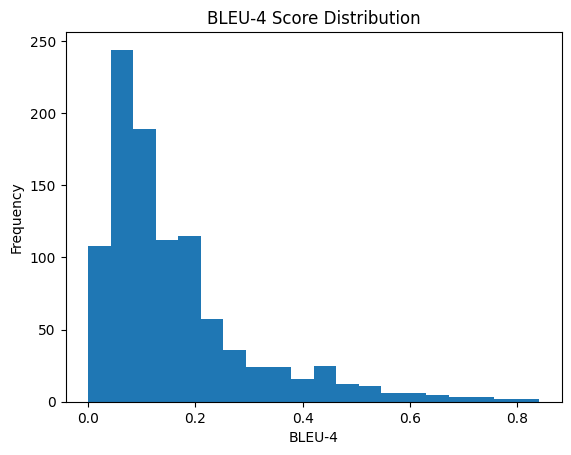

In [10]:
plt.figure()
plt.hist(per_image_bleu4, bins=20)
plt.title("BLEU-4 Score Distribution")
plt.xlabel("BLEU-4")
plt.ylabel("Frequency")
plt.show()


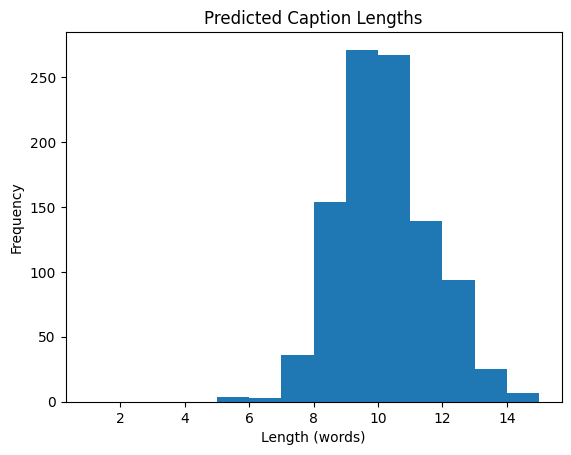

In [11]:
lengths = [len(h) for h in hypotheses]
plt.figure()
plt.hist(lengths, bins=range(1, max(lengths)+2))
plt.title("Predicted Caption Lengths")
plt.xlabel("Length (words)")
plt.ylabel("Frequency")
plt.show()


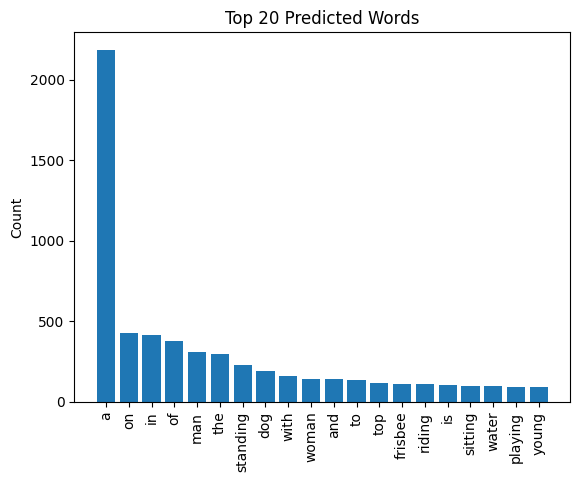

In [12]:
all_words = [w for hyp in hypotheses for w in hyp]
wc = Counter(all_words).most_common(20)
words, counts = zip(*wc)

plt.figure()
plt.bar(range(len(words)), counts)
plt.xticks(range(len(words)), words, rotation=90)
plt.title("Top 20 Predicted Words")
plt.ylabel("Count")
plt.show()


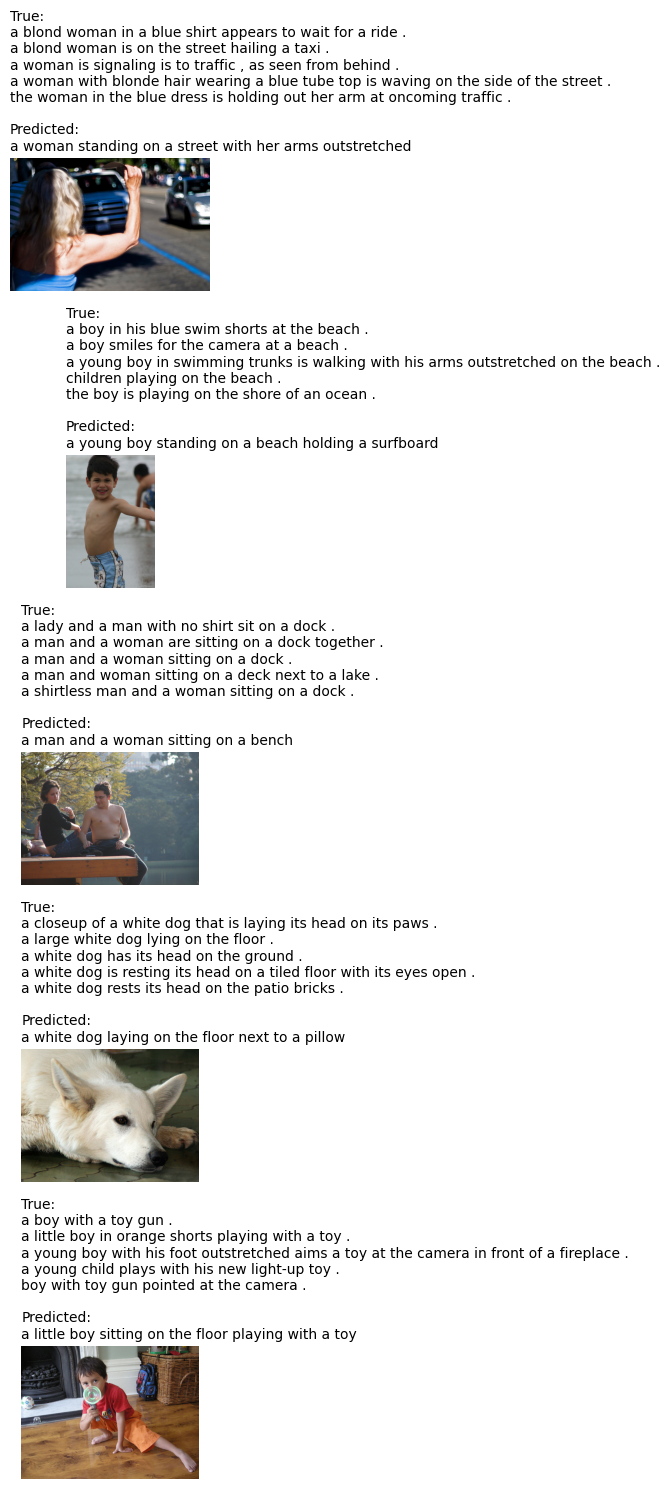

In [13]:
N = 5
plt.figure(figsize=(12, 3*N))
for i in range(N):
    img = Image.open(os.path.join(img_dir, image_names[i])).convert("RGB")
    true_caps = [" ".join(r) for r in refs[image_names[i]][:5]]
    pred_cap = " ".join(hypotheses[i])
    ax = plt.subplot(N,1,i+1)
    ax.imshow(img); ax.axis('off')
    ax.set_title("True:\n" + "\n".join(true_caps) + "\n\nPredicted:\n" + pred_cap, fontsize=10, loc='left')
plt.tight_layout()
plt.show()


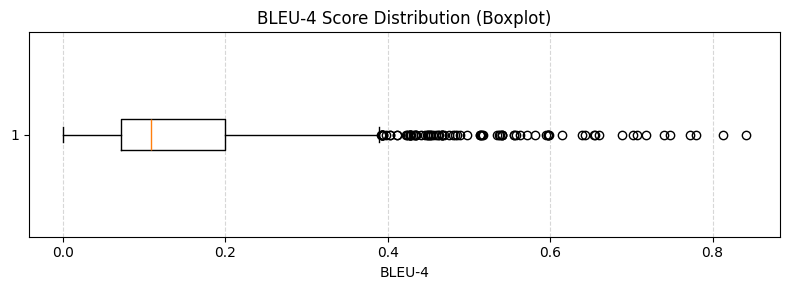

In [14]:
plt.figure(figsize=(8, 3))
plt.boxplot(per_image_bleu4, vert=False)
plt.title("BLEU-4 Score Distribution (Boxplot)")
plt.xlabel("BLEU-4")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


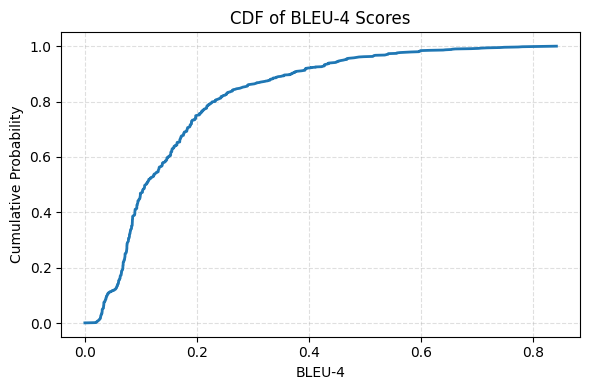

In [15]:
sorted_bleu4 = sorted(per_image_bleu4)
cdf = [i / len(sorted_bleu4) for i in range(1, len(sorted_bleu4) + 1)]

plt.figure(figsize=(6, 4))
plt.plot(sorted_bleu4, cdf, linewidth=2)
plt.title("CDF of BLEU-4 Scores")
plt.xlabel("BLEU-4")
plt.ylabel("Cumulative Probability")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


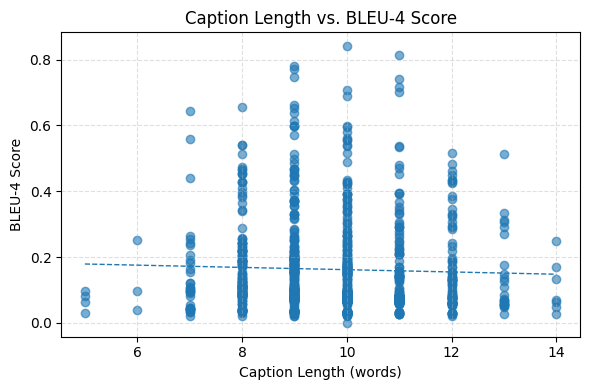

In [16]:
import numpy as np

plt.figure(figsize=(6, 4))
plt.scatter(lengths, per_image_bleu4, alpha=0.6)

m, b = np.polyfit(lengths, per_image_bleu4, 1)
x = np.linspace(min(lengths), max(lengths), 100)
plt.plot(x, m*x + b, linestyle='--', linewidth=1)
plt.title("Caption Length vs. BLEU-4 Score")
plt.xlabel("Caption Length (words)")
plt.ylabel("BLEU-4 Score")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
